In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm


# Evaluate models on RMSE, MAPE, R^2, QLIKE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

def calculate_metrics(actual_log, predicted_log):
	actual = np.exp(actual_log)
	predicted = np.exp(predicted_log)
	mse = mean_squared_error(actual, predicted)
	rmse = np.sqrt(mse)
	mape = mean_absolute_percentage_error(actual, predicted)
	r2 = r2_score(actual, predicted)
	qlike = np.mean(actual/predicted - np.log(actual/predicted) - 1)
	return rmse, mape, r2, qlike


In [2]:
%%latex
$$
\ln\left(\sigma_{t+1}^2\right) = \beta_0 + \beta_1 \ln\left(\sigma_t^2\right) 
+ \beta_2 \ln\left(\frac{1}{7} \sum_{i=0}^{6} \sigma_{t-i}^2\right)
+ \beta_3 \ln\left(\frac{1}{30} \sum_{i=0}^{29} \sigma_{t-i}^2\right) + \epsilon_t,
$$

$$
\ln\left(\sigma_{t+1}^2\right) = f\Biggl( \ln\left(\sigma_t^2\right),\; 
\ln\Bigl(\frac{1}{5} \sum_{i=0}^{4} \sigma_{t-i}^2\Bigr),\;
\ln\Bigl(\frac{1}{22} \sum_{i=0}^{21} \sigma_{t-i}^2\Bigr),\; \text{Volume},\; \ldots \Biggr)
+ \epsilon_t.
$$

where ln_RV_w,t:
$$
 \ln\left(\frac{1}{7} \sum_{i=0}^{4} \sigma_{t-i}^2\right)
$$

<IPython.core.display.Latex object>

%%latex
% Heterogeneous AutoRegressive (HAR) Model Equation:
\[
\ln\left(\sigma_{t+1}^2\right) = \beta_0 + \beta_1\, \text{ln\_RV\_d,t} + \beta_2\, \text{ln\_RV\_w,t} + \beta_3\, \text{ln\_RV\_m,t} + \epsilon_t.
\]

% Random Forest (RF) Model Equation:
\[
\ln\left(\sigma_{t+1}^2\right) = f\Bigl( \text{ln\_RV\_d,t},\; \text{ln\_RV\_w,t},\; \text{ln\_RV\_m,t},\; \text{volume},\; \text{UEMP15T26},\; \text{UEMP27OV},\; \text{PERMITW},\; \text{TB3SMFFM},\; \text{Fear\_Greed\_Value} \Bigr) + \epsilon_t.
\]

## One-Regime Baseline RF and HAR

Train Set date ranges:  2018-02-01 00:00:00 2021-09-19 00:00:00
Test Set date ranges:  2021-09-20 00:00:00 2023-03-30 00:00:00


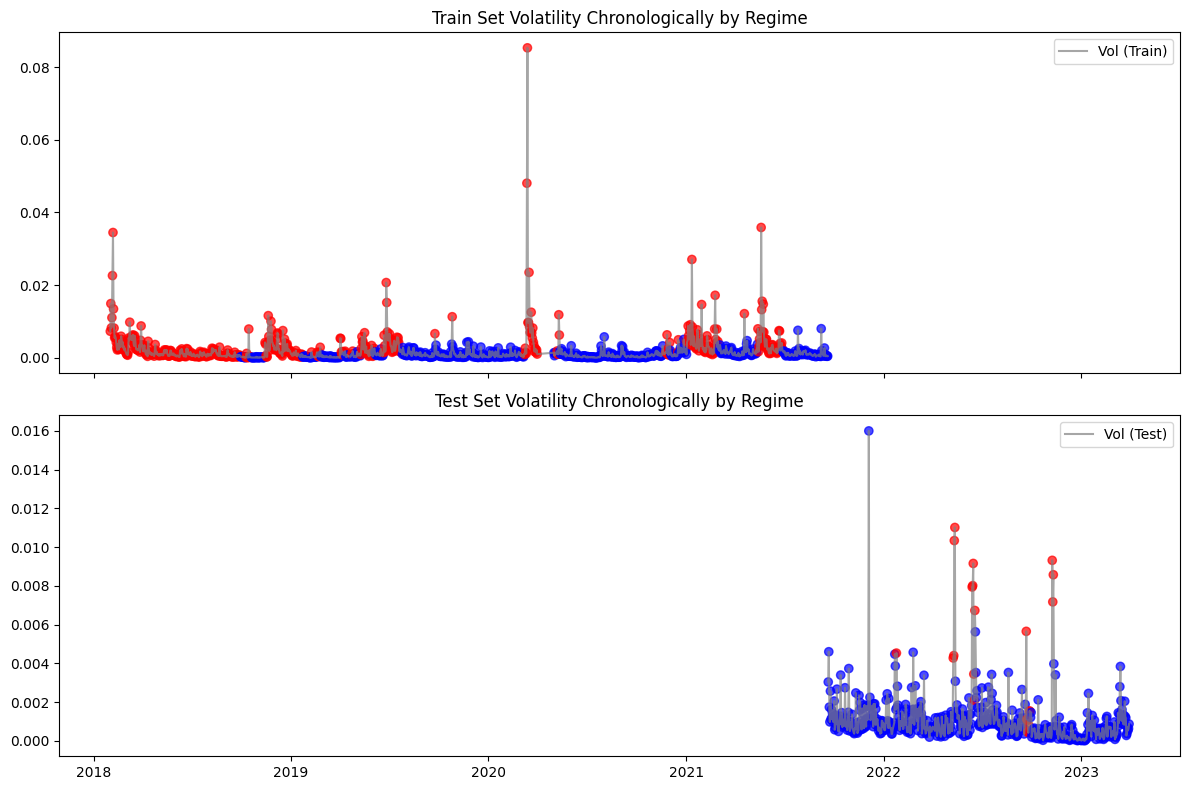

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     759.0
Date:                Fri, 04 Apr 2025   Prob (F-statistic):          1.61e-284
Time:                        08:30:17   Log-Likelihood:                -1356.3
No. Observations:                1297   AIC:                             2721.
Df Residuals:                    1293   BIC:                             2741.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6024      0.159     -3.798      0.0

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_72334/777288815.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_reg_test['RF_Pred'] = one_reg_y_pred_rf
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_72334/777288815.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_reg_test['HAR_Pred'] = one_reg_y_pred_har


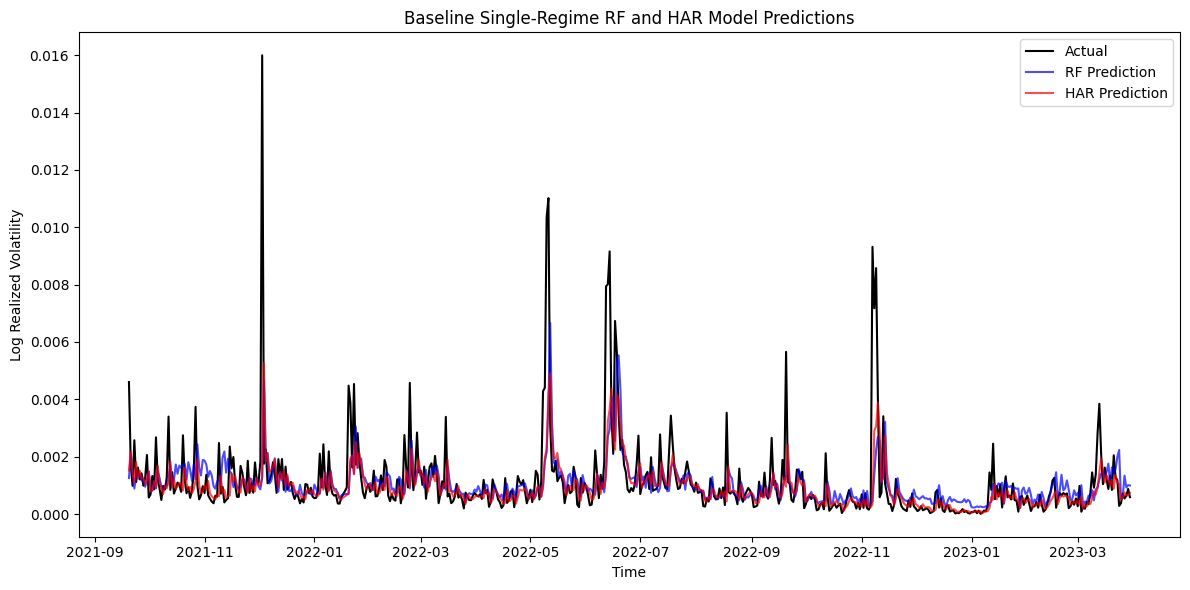

In [3]:
data = pd.read_csv('../data/data.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

features_1 = ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t','high', 'volume', 
            'UEMP15T26', 'UEMP27OV', 'PERMITW', 'TB3SMFFM', 'Fear_Greed_Value']

#80% train, 20% test
one_reg_train = data[:int(0.7*(len(data)))]
one_reg_test = data[int(0.7*(len(data))):]
#print train and test date ranges
print("Train Set date ranges: ", one_reg_train.index.min(), one_reg_train.index.max())
print("Test Set date ranges: ", one_reg_test.index.min(), one_reg_test.index.max())
# print the train and test data coloured by regime
# Plot distribution
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)

# Plot the train set
ax[0].plot(one_reg_train.index, np.exp(one_reg_train['ln_RV_d,t']), label='Vol (Train)', color='gray', alpha=0.7)
colors_train = one_reg_train['Regime'].map({'High Volatility': 'red', 'Low Volatility': 'blue'})
ax[0].scatter(one_reg_train.index, np.exp(one_reg_train['ln_RV_d,t']), c=colors_train, alpha=0.7, marker='o')
ax[0].set_title("Train Set Volatility Chronologically by Regime")
ax[0].legend()

# Plot the test set
ax[1].plot(one_reg_test.index, np.exp(one_reg_test['ln_RV_d,t']), label='Vol (Test)', color='gray', alpha=0.7)
colors_test = one_reg_test['Regime'].map({'High Volatility': 'red', 'Low Volatility': 'blue'})
ax[1].scatter(one_reg_test.index, np.exp(one_reg_test['ln_RV_d,t']), c=colors_test, alpha=0.7, marker='o')
ax[1].set_title("Test Set Volatility Chronologically by Regime")
ax[1].legend()

plt.tight_layout()
plt.show()

#scale data 
one_reg_scaler = StandardScaler()
one_reg_train_scaled = one_reg_scaler.fit_transform(one_reg_train[features_1])
one_reg_test_scaled = one_reg_scaler.transform(one_reg_test[features_1])

#X and y
one_reg_X_train = one_reg_train_scaled
one_reg_y_train = one_reg_train['target']
one_reg_X_test = one_reg_test_scaled
one_reg_y_test = one_reg_test['target']
# Fit baseline Random Forest Regressor (Single-Regime)
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(one_reg_X_train, one_reg_y_train)
one_reg_y_pred_rf = rf.predict(one_reg_X_test)
one_reg_test['RF_Pred'] = one_reg_y_pred_rf

# Fit baseline HAR model (Single-Regime)
one_reg_X_train_har = sm.add_constant(one_reg_train[['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t']])
one_reg_X_test_har = sm.add_constant(one_reg_test[['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t']])

har_model = sm.OLS(one_reg_y_train, one_reg_X_train_har).fit()
one_reg_y_pred_har = har_model.predict(one_reg_X_test_har)
one_reg_test['HAR_Pred'] = one_reg_y_pred_har

# Print HAR model summary
print(har_model.summary())

print("One Regime Random Forest Results:", calculate_metrics(one_reg_y_test, one_reg_y_pred_rf))
print("One Regime HAR Model Results:", calculate_metrics(one_reg_y_test, one_reg_y_pred_har))

# Plot predictions
plt.figure(figsize=(12,6))
plt.plot(one_reg_test.index, np.exp(one_reg_y_test), label='Actual', color='black')
plt.plot(one_reg_test.index, np.exp(one_reg_y_pred_rf), label='RF Prediction', color='blue', alpha=0.7)
plt.plot(one_reg_test.index, np.exp(one_reg_y_pred_har), label='HAR Prediction', color='red', alpha=0.7)
plt.legend()
plt.title("Baseline Single-Regime RF and HAR Model Predictions")
plt.xlabel("Time")
plt.ylabel("Log Realized Volatility")
plt.tight_layout()
plt.show()

In [4]:

two_reg_train = pd.read_csv('../data/train.csv')
two_reg_test = pd.read_csv('../data/test.csv')
two_reg_train.set_index('date', inplace=True)
two_reg_test.set_index('date', inplace=True)

features_2 = ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t', 'high', 'volume',
        'UEMP15T26', 'UEMP27OV', 'PERMITW', 'TB3SMFFM', 'Fear_Greed_Value']

#print train and test date ranges
print("Two Regime Train Set date ranges: ", two_reg_train.index.min(), two_reg_train.index.max())
print("Two Regime Test Set date ranges: ", two_reg_test.index.min(), two_reg_test.index.max())

#scale data 
two_reg_scaler = StandardScaler()
two_reg_train_scaled = two_reg_scaler.fit_transform(two_reg_train[features_2])
two_reg_test_scaled = two_reg_scaler.transform(two_reg_test[features_2])

#X and y
two_reg_X_train = two_reg_train_scaled
two_reg_y_train = two_reg_train['target']
two_reg_X_test = two_reg_test_scaled 
two_reg_y_test = two_reg_test['target']




Two Regime Train Set date ranges:  2018-02-01 2022-02-17
Two Regime Test Set date ranges:  2019-07-23 2023-03-30


## Two-Regime HAR and RF models

In [5]:
def train_two_regime_models(train_df, test_df, X_train_scaled, X_test_scaled, feature_names):
    """
    Train separate HAR and RF models for each volatility regime using scaled features.

    Parameters:
    - train_df, test_df: DataFrames with at least the columns "Regime" and "target"
      (target is in log-scale, unscaled).
    - X_train_scaled, X_test_scaled: numpy arrays containing the scaled features,
      produced from StandardScaler.
    - feature_names: list of feature names corresponding to the columns in the scaled arrays.
      For instance: 
          ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t', 'volume',
           'UEMP15T26', 'UEMP27OV', 'PERMITW', 'TB3SMFFM', 'Fear_Greed_Value']

    The HAR model uses only the volatility columns ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t'].
    The RF model uses all provided features.
    """
    # Convert scaled arrays back to DataFrames for easier subsetting
    X_train_df = pd.DataFrame(X_train_scaled, index=train_df.index, columns=feature_names)
    X_test_df = pd.DataFrame(X_test_scaled, index=test_df.index, columns=feature_names)
    
    # Define feature lists for HAR and RF models.
    har_features = ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t']  # HAR uses these volatility columns
    rf_features = feature_names  # RF uses all features
    
    # Dictionaries to store the trained models
    har_models = {}
    rf_models = {}
    
    # Train separate models for each regime.
    for regime_label in ['High Volatility', 'Low Volatility']:
        # Subset the training data based on regime.
        idx = train_df[train_df['Regime'] == regime_label].index
        subset_train_df = train_df.loc[idx]
        
        # HAR Model (OLS)
        X_har = X_train_df.loc[idx, har_features]
        X_har = sm.add_constant(X_har)
        y_har = subset_train_df['target']
        
        har_model = sm.OLS(y_har, X_har).fit()
        har_models[regime_label] = har_model
        
        # Random Forest Model
        X_rf = X_train_df.loc[idx, rf_features].values
        y_rf = subset_train_df['target'].values
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_rf, y_rf)
        rf_models[regime_label] = rf_model
        
    # Make predictions on the test set.
    test_df = test_df.copy()
    test_df['HAR_Pred'] = np.nan
    test_df['RF_Pred'] = np.nan
    
    for regime_label in ['High Volatility', 'Low Volatility']:
        idx_test = test_df[test_df['Regime'] == regime_label].index
        subset_test_df = test_df.loc[idx_test]
        
        # HAR Prediction
        X_har_test = X_test_df.loc[idx_test, har_features]
        X_har_test = sm.add_constant(X_har_test)
        test_df.loc[idx_test, 'HAR_Pred'] = har_models[regime_label].predict(X_har_test)
        
        # RF Prediction
        X_rf_test = X_test_df.loc[idx_test, rf_features].values
        test_df.loc[idx_test, 'RF_Pred'] = rf_models[regime_label].predict(X_rf_test)
        
    # Evaluate performance using the calculate_metrics function (converting from log to level).
    results = {}
    for regime in ['High Volatility', 'Low Volatility', 'All']:
        if regime == 'All':
            df_eval = test_df.dropna(subset=['target', 'HAR_Pred', 'RF_Pred'])
        else:
            df_eval = test_df[test_df['Regime'] == regime].dropna(subset=['target', 'HAR_Pred', 'RF_Pred'])
        if len(df_eval) == 0:
            continue
        
        har_metrics = calculate_metrics(df_eval['target'], df_eval['HAR_Pred'])
        rf_metrics  = calculate_metrics(df_eval['target'], df_eval['RF_Pred'])
        
        results[regime] = {'HAR': har_metrics, 'RF': rf_metrics}
        
        print(f"\n=== {regime} Metrics ===")
        print(f"HAR : RMSE={har_metrics[0]:.6f}, MAPE={har_metrics[1]:.4f}, R²={har_metrics[2]:.4f}, QLIKE={har_metrics[3]:.4f}")
        print(f"RF  : RMSE={rf_metrics[0]:.6f},  MAPE={rf_metrics[1]:.4f},  R²={rf_metrics[2]:.4f},  QLIKE={rf_metrics[3]:.4f}")
        
    return har_models, rf_models, test_df, results

In [6]:
two_reg_har_models, two_reg_rf_models, two_reg_test_df, two_reg_results = train_two_regime_models(
    												two_reg_train, two_reg_test, two_reg_train_scaled, two_reg_test_scaled, features_2)


=== High Volatility Metrics ===
HAR : RMSE=0.007944, MAPE=0.4412, R²=0.0897, QLIKE=0.5782
RF  : RMSE=0.008050,  MAPE=0.5304,  R²=0.0653,  QLIKE=0.7126

=== Low Volatility Metrics ===
HAR : RMSE=0.000869, MAPE=0.6681, R²=0.1376, QLIKE=0.3297
RF  : RMSE=0.000874,  MAPE=1.0614,  R²=0.1264,  QLIKE=0.3476

=== All Metrics ===
HAR : RMSE=0.004473, MAPE=0.5980, R²=0.2343, QLIKE=0.4064
RF  : RMSE=0.004532,  MAPE=0.8974,  R²=0.2141,  QLIKE=0.4603


Missing Dates in Test Set:  DatetimeIndex(['2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04',
               ...
               '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
               '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15',
               '2022-02-16', '2022-02-17'],
              dtype='datetime64[ns]', length=790, freq=None)


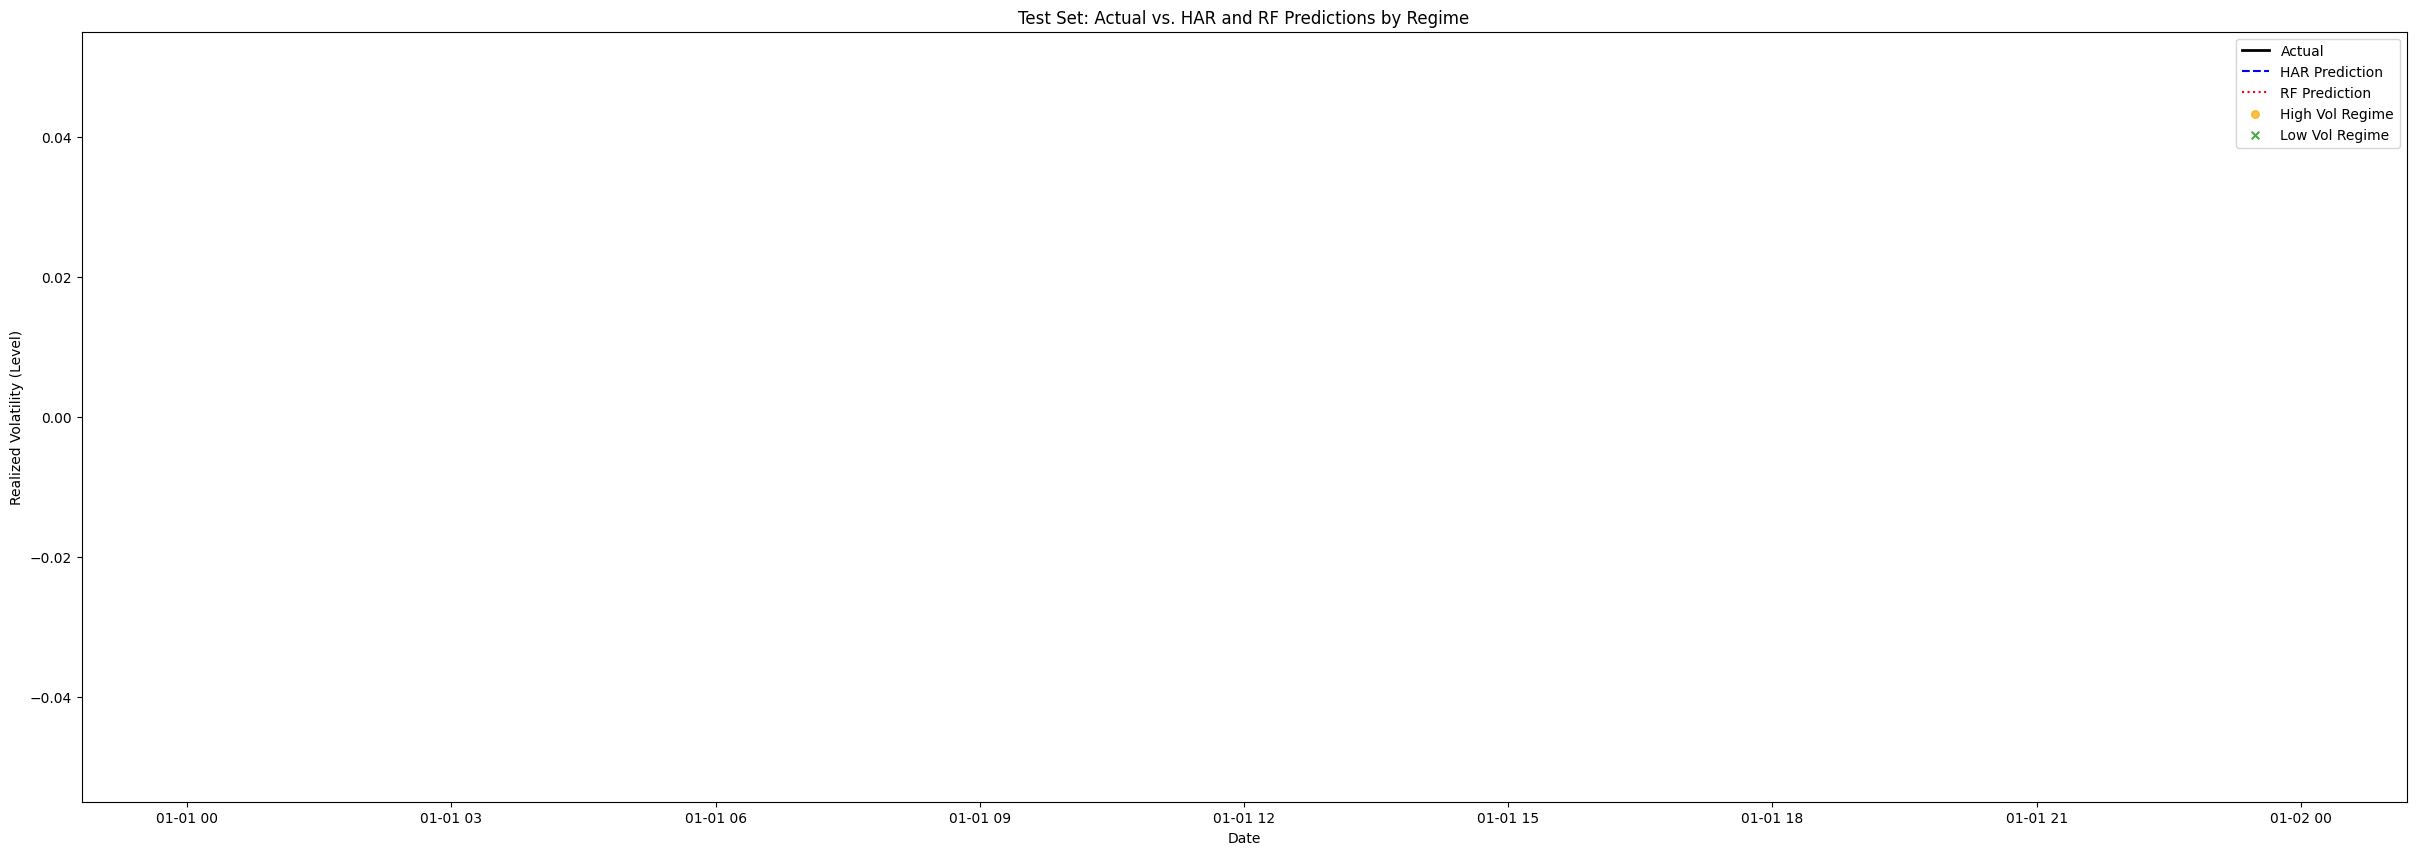

In [9]:
plot_df = two_reg_test_df[['target', 'HAR_Pred', 'RF_Pred', 'Regime']].copy()
# Convert log-scale to level for plotting
plot_df['target'] = np.exp(plot_df['target'])
plot_df['HAR_Pred'] = np.exp(plot_df['HAR_Pred'])
plot_df['RF_Pred'] = np.exp(plot_df['RF_Pred'])

#print missing dates within test_df date range
missing_dates = pd.date_range(start=two_reg_test.index.min(), end=two_reg_test.index.max()).difference(two_reg_test.index)
print("Missing Dates in Test Set: ", missing_dates)

#reindex on full date range
full_index = pd.date_range(start=plot_df.index.min(), end=plot_df.index.max(), freq='D')
plot_df = plot_df.reindex(full_index)

plt.figure(figsize=(30,10))

# Plot actual volatility levels
plt.plot(plot_df.index, plot_df['target'], label="Actual", color='black', linewidth=2)

# Plot HAR and RF predictions
plt.plot(plot_df.index, plot_df['HAR_Pred'], label="HAR Prediction", color='blue', linestyle='--', linewidth=1.5)
plt.plot(plot_df.index, plot_df['RF_Pred'], label="RF Prediction", color='red', linestyle=':', linewidth=1.5)

# Optionally, highlight regimes with scatter markers
high_regime = plot_df[plot_df['Regime'] == 'High Volatility']
low_regime  = plot_df[plot_df['Regime'] == 'Low Volatility']

plt.scatter(high_regime.index, high_regime['target'], label="High Vol Regime", 
            color='orange', s=30, marker='o', alpha=0.7)
plt.scatter(low_regime.index, low_regime['target'], label="Low Vol Regime", 
            color='green', s=30, marker='x', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Realized Volatility (Level)")
plt.title("Test Set: Actual vs. HAR and RF Predictions by Regime")
plt.legend()
plt.show()

## Finding a basis for comparison of 1-Regime and 2-Regime Models



In [8]:
#####################################
# 1. One-Regime Baseline Evaluation
#####################################

# Overall performance for one-regime model (on its original test set)
one_reg_overall_metrics_rf  = calculate_metrics(one_reg_test['target'], one_reg_test['RF_Pred'])
one_reg_overall_metrics_har = calculate_metrics(one_reg_test['target'], one_reg_test['HAR_Pred'])
num_one_reg = len(one_reg_test)
num_one_reg_high = len(one_reg_test[one_reg_test['Regime'] == 'High Volatility'])
num_one_reg_low  = len(one_reg_test[one_reg_test['Regime'] == 'Low Volatility'])

print("One-Regime Baseline (Original Test Set) Metrics:")
print("Number of Predictions:", num_one_reg)
print("  High Volatility:", num_one_reg_high)
print("  Low Volatility:", num_one_reg_low)
print("Overall RF Metrics (One-Regime):", one_reg_overall_metrics_rf)
print("Overall HAR Metrics (One-Regime):", one_reg_overall_metrics_har)

# One-Regime performance split by regime
one_reg_high_metrics_rf = calculate_metrics(
    one_reg_test[one_reg_test['Regime'] == 'High Volatility']['target'],
    one_reg_test[one_reg_test['Regime'] == 'High Volatility']['RF_Pred']
)
one_reg_low_metrics_rf  = calculate_metrics(
    one_reg_test[one_reg_test['Regime'] == 'Low Volatility']['target'],
    one_reg_test[one_reg_test['Regime'] == 'Low Volatility']['RF_Pred']
)
one_reg_high_metrics_har = calculate_metrics(
    one_reg_test[one_reg_test['Regime'] == 'High Volatility']['target'],
    one_reg_test[one_reg_test['Regime'] == 'High Volatility']['HAR_Pred']
)
one_reg_low_metrics_har  = calculate_metrics(
    one_reg_test[one_reg_test['Regime'] == 'Low Volatility']['target'],
    one_reg_test[one_reg_test['Regime'] == 'Low Volatility']['HAR_Pred']
)

print("\nOne-Regime RF Metrics by Regime:")
print("  High Volatility:", one_reg_high_metrics_rf)
print("  Low Volatility:", one_reg_low_metrics_rf)
print("\nOne-Regime HAR Metrics by Regime:")
print("  High Volatility:", one_reg_high_metrics_har)
print("  Low Volatility:", one_reg_low_metrics_har)

#####################################
# 2. Two-Regime Model Evaluation (Stratified Test Set)
#####################################

two_reg_overall_metrics_rf  = calculate_metrics(two_reg_test_df['target'], two_reg_test_df['RF_Pred'])
two_reg_overall_metrics_har = calculate_metrics(two_reg_test_df['target'], two_reg_test_df['HAR_Pred'])
num_two_reg = len(two_reg_test_df)
num_two_reg_high = len(two_reg_test_df[two_reg_test_df['Regime'] == 'High Volatility'])
num_two_reg_low  = len(two_reg_test_df[two_reg_test_df['Regime'] == 'Low Volatility'])

print("\nTwo-Regime (Stratified Test Set) Metrics:")
print("Number of Predictions:", num_two_reg)
print("  High Volatility:", num_two_reg_high)
print("  Low Volatility:", num_two_reg_low)
print("Overall RF Metrics (Two-Regime):", two_reg_overall_metrics_rf)
print("Overall HAR Metrics (Two-Regime):", two_reg_overall_metrics_har)

# Two-Regime performance split by regime
two_reg_high_metrics_rf = calculate_metrics(
    two_reg_test_df[two_reg_test_df['Regime'] == 'High Volatility']['target'],
    two_reg_test_df[two_reg_test_df['Regime'] == 'High Volatility']['RF_Pred']
)
two_reg_low_metrics_rf  = calculate_metrics(
    two_reg_test_df[two_reg_test_df['Regime'] == 'Low Volatility']['target'],
    two_reg_test_df[two_reg_test_df['Regime'] == 'Low Volatility']['RF_Pred']
)
two_reg_high_metrics_har = calculate_metrics(
    two_reg_test_df[two_reg_test_df['Regime'] == 'High Volatility']['target'],
    two_reg_test_df[two_reg_test_df['Regime'] == 'High Volatility']['HAR_Pred']
)
two_reg_low_metrics_har  = calculate_metrics(
    two_reg_test_df[two_reg_test_df['Regime'] == 'Low Volatility']['target'],
    two_reg_test_df[two_reg_test_df['Regime'] == 'Low Volatility']['HAR_Pred']
)

print("\nTwo-Regime RF Metrics by Regime:")
print("  High Volatility:", two_reg_high_metrics_rf)
print("  Low Volatility:", two_reg_low_metrics_rf)
print("\nTwo-Regime HAR Metrics by Regime:")
print("  High Volatility:", two_reg_high_metrics_har)
print("  Low Volatility:", two_reg_low_metrics_har)

#####################################
# 3. Combined Common Dates Evaluation
#####################################

# Find common dates between the one-regime and two-regime test sets
common_dates = two_reg_test_df.index.intersection(one_reg_test.index)
test_df_common = two_reg_test_df.loc[common_dates]

# One-regime predictions for the common dates
y_pred_rf_common = one_reg_y_pred_rf[one_reg_test.index.isin(common_dates)]
y_pred_har_common = one_reg_y_pred_har[one_reg_test.index.isin(common_dates)]

# Overall common dates metrics
one_reg_common_rf = calculate_metrics(test_df_common['target'], y_pred_rf_common)
one_reg_common_har = calculate_metrics(test_df_common['target'], y_pred_har_common)
two_reg_common_rf = calculate_metrics(test_df_common['target'], test_df_common['RF_Pred'])
two_reg_common_har = calculate_metrics(test_df_common['target'], test_df_common['HAR_Pred'])

print("\nCommon Dates Overall Metrics:")
print("One-Regime RF:", one_reg_common_rf)
print("One-Regime HAR:", one_reg_common_har)
print("Two-Regime RF:", two_reg_common_rf)
print("Two-Regime HAR:", two_reg_common_har)

# Count common dates predictions
num_common = len(test_df_common)
num_common_high = len(test_df_common[test_df_common['Regime'] == 'High Volatility'])
num_common_low  = len(test_df_common[test_df_common['Regime'] == 'Low Volatility'])

print("\nNumber of Predictions in the Common Dates Test Set:")
print("  Total:", num_common)
print("  High Volatility:", num_common_high)
print("  Low Volatility:", num_common_low)

# Common dates metrics split by regime
print("\nOne-Regime RF Metrics (Common Dates) for High Volatility:")
print(calculate_metrics(test_df_common[test_df_common['Regime'] == 'High Volatility']['target'], 
                        y_pred_rf_common[test_df_common['Regime'] == 'High Volatility']))
print("One-Regime RF Metrics (Common Dates) for Low Volatility:")
print(calculate_metrics(test_df_common[test_df_common['Regime'] == 'Low Volatility']['target'], 
                        y_pred_rf_common[test_df_common['Regime'] == 'Low Volatility']))
print("One-Regime HAR Metrics (Common Dates) for High Volatility:")
print(calculate_metrics(test_df_common[test_df_common['Regime'] == 'High Volatility']['target'], 
                        y_pred_har_common[test_df_common['Regime'] == 'High Volatility']))
print("One-Regime HAR Metrics (Common Dates) for Low Volatility:")
print(calculate_metrics(test_df_common[test_df_common['Regime'] == 'Low Volatility']['target'], 
                        y_pred_har_common[test_df_common['Regime'] == 'Low Volatility']))

print("\nTwo-Regime RF Metrics (Common Dates) for High Volatility:")
print(calculate_metrics(test_df_common[test_df_common['Regime'] == 'High Volatility']['target'], 
                        test_df_common[test_df_common['Regime'] == 'High Volatility']['RF_Pred']))
print("Two-Regime RF Metrics (Common Dates) for Low Volatility:")
print(calculate_metrics(test_df_common[test_df_common['Regime'] == 'Low Volatility']['target'], 
                        test_df_common[test_df_common['Regime'] == 'Low Volatility']['RF_Pred']))
print("Two-Regime HAR Metrics (Common Dates) for High Volatility:")
print(calculate_metrics(test_df_common[test_df_common['Regime'] == 'High Volatility']['target'], 
                        test_df_common[test_df_common['Regime'] == 'High Volatility']['HAR_Pred']))
print("Two-Regime HAR Metrics (Common Dates) for Low Volatility:")
print(calculate_metrics(test_df_common[test_df_common['Regime'] == 'Low Volatility']['target'], 
                        test_df_common[test_df_common['Regime'] == 'Low Volatility']['HAR_Pred']))

One-Regime Baseline (Original Test Set) Metrics:
Number of Predictions: 557
  High Volatility: 22
  Low Volatility: 535
Overall RF Metrics (One-Regime): (0.0013013665927578103, 1.063822483475295, 0.1802460011229745, 0.31746745512369773)
Overall HAR Metrics (One-Regime): (0.0012480805625390973, 0.6101524209034404, 0.24600324731937973, 0.30308933796928894)

One-Regime RF Metrics by Regime:
  High Volatility: (0.00372087616115436, 0.5503729112460045, -0.19820649245640576, 0.5217557785842316)
  Low Volatility: (0.0010926448345367648, 1.0849362976604247, 0.05005399089281015, 0.3090668137851337)

One-Regime HAR Metrics by Regime:
  High Volatility: (0.003371418111668375, 0.4989726855414893, 0.01629140130782658, 0.34696320164412653)
  Low Volatility: (0.0010744088690878108, 0.6147242978715954, 0.0814981020865243, 0.3012851790892022)

Two-Regime (Stratified Test Set) Metrics:
Number of Predictions: 557
  High Volatility: 172
  Low Volatility: 385
Overall RF Metrics (Two-Regime): (0.00453202579

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
results_dict = {
    # One-Regime Baseline on original test set
    "One-Regime Overall - RF": one_reg_overall_metrics_rf,
    "One-Regime Overall - HAR": one_reg_overall_metrics_har,
    "One-Regime High - RF": one_reg_high_metrics_rf,
    "One-Regime High - HAR": one_reg_high_metrics_har,
    "One-Regime Low - RF": one_reg_low_metrics_rf,
    "One-Regime Low - HAR": one_reg_low_metrics_har,
    
    # Two-Regime (Stratified) on original test set
    "Two-Regime Overall - RF": two_reg_overall_metrics_rf,
    "Two-Regime Overall - HAR": two_reg_overall_metrics_har,
    "Two-Regime High - RF": two_reg_high_metrics_rf,
    "Two-Regime High - HAR": two_reg_high_metrics_har,
    "Two-Regime Low - RF": two_reg_low_metrics_rf,
    "Two-Regime Low - HAR": two_reg_low_metrics_har,
    
    # Common Dates (overall)
    "One-Regime Common Overall - RF": one_reg_common_rf,
    "One-Regime Common Overall - HAR": one_reg_common_har,
    "Two-Regime Common Overall - RF": two_reg_common_rf,
    "Two-Regime Common Overall - HAR": two_reg_common_har,
    
    # Common Dates split by regime
    "One-Regime Common High - RF": calculate_metrics(
        test_df_common[test_df_common['Regime'] == 'High Volatility']['target'],
        y_pred_rf_common[test_df_common['Regime'] == 'High Volatility']
    ),
    "One-Regime Common High - HAR": calculate_metrics(
        test_df_common[test_df_common['Regime'] == 'High Volatility']['target'],
        y_pred_har_common[test_df_common['Regime'] == 'High Volatility']
    ),
    "One-Regime Common Low - RF": calculate_metrics(
        test_df_common[test_df_common['Regime'] == 'Low Volatility']['target'],
        y_pred_rf_common[test_df_common['Regime'] == 'Low Volatility']
    ),
    "One-Regime Common Low - HAR": calculate_metrics(
        test_df_common[test_df_common['Regime'] == 'Low Volatility']['target'],
        y_pred_har_common[test_df_common['Regime'] == 'Low Volatility']
    ),
    "Two-Regime Common High - RF": calculate_metrics(
        test_df_common[test_df_common['Regime'] == 'High Volatility']['target'],
        test_df_common[test_df_common['Regime'] == 'High Volatility']['RF_Pred']
    ),
    "Two-Regime Common High - HAR": calculate_metrics(
        test_df_common[test_df_common['Regime'] == 'High Volatility']['target'],
        test_df_common[test_df_common['Regime'] == 'High Volatility']['HAR_Pred']
    ),
    "Two-Regime Common Low - RF": calculate_metrics(
        test_df_common[test_df_common['Regime'] == 'Low Volatility']['target'],
        test_df_common[test_df_common['Regime'] == 'Low Volatility']['RF_Pred']
    ),
    "Two-Regime Common Low - HAR": calculate_metrics(
        test_df_common[test_df_common['Regime'] == 'Low Volatility']['target'],
        test_df_common[test_df_common['Regime'] == 'Low Volatility']['HAR_Pred']
    )
}

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['RMSE', 'MAPE', 'R2', 'QLIKE'])
results_df.index.name = 'Model-Regime'
results_df = results_df.sort_index()

# Define a dictionary mapping each metric key to its corresponding count
counts_dict = {
    "One-Regime Overall - RF": num_one_reg,
    "One-Regime Overall - HAR": num_one_reg,
    "One-Regime High - RF": num_one_reg_high,
    "One-Regime High - HAR": num_one_reg_high,
    "One-Regime Low - RF": num_one_reg_low,
    "One-Regime Low - HAR": num_one_reg_low,
    
    "Two-Regime Overall - RF": num_two_reg,
    "Two-Regime Overall - HAR": num_two_reg,
    "Two-Regime High - RF": num_two_reg_high,
    "Two-Regime High - HAR": num_two_reg_high,
    "Two-Regime Low - RF": num_two_reg_low,
    "Two-Regime Low - HAR": num_two_reg_low,
    
    "One-Regime Common Overall - RF": num_common,
    "One-Regime Common Overall - HAR": num_common,
    "Two-Regime Common Overall - RF": num_common,
    "Two-Regime Common Overall - HAR": num_common,
    
    "One-Regime Common High - RF": num_common_high,
    "One-Regime Common High - HAR": num_common_high,
    "One-Regime Common Low - RF": num_common_low,
    "One-Regime Common Low - HAR": num_common_low,
    "Two-Regime Common High - RF": num_common_high,
    "Two-Regime Common High - HAR": num_common_high,
    "Two-Regime Common Low - RF": num_common_low,
    "Two-Regime Common Low - HAR": num_common_low
}

# Add the 'Count' column to the DataFrame by mapping the index to counts
results_df['Count'] = results_df.index.map(counts_dict)



results_df = results_df.sort_index()
# Print the final DataFrame
print("Comparison Metrics:")
print(results_df)

# Save to CSV if needed
results_df.to_csv("model_comparison_metrics.csv")

# Read the CSV file into a DataFrame.
df_metrics = pd.read_csv("model_comparison_metrics.csv")

# Optionally, rename columns for LaTeX formatting (adjust column names as needed).
# For example, if your CSV columns are: "Model-Regime", "RMSE", "MAPE", "R2", "QLIKE", "Count"
df_metrics.rename(columns={"R2": "R\$^2\$",
                           "MAPE": "MAPE (\%)"}, inplace=True)

# Convert the DataFrame to a LaTeX table.
latex_table = df_metrics.to_latex(index=False,
                                  float_format="%.4f",
                                  caption="Model Performance Metrics Across Forecasting Approaches",
                                  label="tab:model_performance_metrics")

#print(latex_table)

Comparison Metrics:
                                     RMSE      MAPE        R2     QLIKE  Count
Model-Regime                                                                  
One-Regime Common High - HAR     0.003371  0.498973  0.016291  0.346963     22
One-Regime Common High - RF      0.003721  0.550373 -0.198206  0.521756     22
One-Regime Common Low - HAR      0.000870  0.688919  0.134984  0.325090    385
One-Regime Common Low - RF       0.000887  1.276984  0.100307  0.329800    385
One-Regime Common Overall - HAR  0.001153  0.678651  0.346335  0.326273    407
One-Regime Common Overall - RF   0.001222  1.237707  0.266403  0.340176    407
One-Regime High - HAR            0.003371  0.498973  0.016291  0.346963     22
One-Regime High - RF             0.003721  0.550373 -0.198206  0.521756     22
One-Regime Low - HAR             0.001074  0.614724  0.081498  0.301285    535
One-Regime Low - RF              0.001093  1.084936  0.050054  0.309067    535
One-Regime Overall - HAR        

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_75710/405148769.py:117: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_metrics.to_latex(index=False,


## Significance testing

I have 4 models, One-regime and two-regime HAR and RF respectively. 
Across each, I have predictions for high vol regimes, low vol regimes and both regimes. 
I use the Common test dates data set to compare the performance of these 4 models.
The initial RMSE results show that:
- Both HAR models outperform the corresponding RF models, in both regimes.
- Both Two Regime models outperform the corresponding One Regime models, in both regimes.
- Two-Regime HAR performs the best of all 4 models.
I perform statistical tests using a Diebold-Mariano Test, to determine if the losses across the 4 models are statistically different, for each regime. 

In [ ]:

from dm_test import dm_test


common_data = test_df_common.dropna()

model_columns = ['OneRegHAR', 'OneRegRF', 'TwoRegHAR', 'TwoRegRF']
forecasts_overall = {
    'OneRegHAR': np.exp(y_pred_har_common),  # one-regime HAR forecasts (level scale)
    'OneRegRF': np.exp(y_pred_rf_common),      # one-regime RF forecasts (level scale)
    'TwoRegHAR': np.exp(common_data['HAR_Pred'].values),  # two-regime HAR forecasts (level scale)
    'TwoRegRF': np.exp(common_data['RF_Pred'].values)       # two-regime RF forecasts (level scale)
}

# Actual values on level-scale
actual_overall = np.exp(common_data['target'].values)

# ---------------------------------------------------
# Pairwise DM Tests: Overall (Common Test Dates)
# ---------------------------------------------------
results = []
for i in range(len(model_columns)):
    for j in range(i + 1, len(model_columns)):
        model1_name = model_columns[i]
        model2_name = model_columns[j]
        forecast1 = forecasts_overall[model1_name]
        forecast2 = forecasts_overall[model2_name]
        # Perform the DM test with h=1 (one-step-ahead) and squared error loss (default in dm_test)
        dm_stat, p_value = dm_test(actual_overall, forecast1, forecast2, h=1)
        results.append((model1_name, model2_name, dm_stat, p_value))

# Create a DataFrame to display overall results
results_df = pd.DataFrame(results, columns=['Model 1', 'Model 2', 'DM Statistic', 'P-Value'])
alpha = 0.05

def interpret_dm_test(row, alpha):
    model1 = row['Model 1']
    model2 = row['Model 2']
    dm_stat = row['DM Statistic']
    p_value = row['P-Value']
    if p_value < alpha:
        if dm_stat > 0:
            conclusion = f"Significant difference; {model2} outperforms {model1}."
        else:
            conclusion = f"Significant difference; {model1} outperforms {model2}."
    else:
        conclusion = "No significant difference; similar predictive accuracy."
    return conclusion

results_df['Conclusion'] = results_df.apply(interpret_dm_test, axis=1, alpha=alpha)
print("=== DM Test Results: Overall (Common Test Dates) ===")
print(results_df[['Model 1', 'Model 2', 'DM Statistic', 'P-Value', 'Conclusion']])
results_df.to_csv('dm_test_results_overall.csv', index=False)

# ---------------------------------------------------
# DM Tests: Regime-Specific (High and Low Volatility)
# ---------------------------------------------------
def run_dm_for_regime(common_data, regime_label):
    # Subset the common data for the given regime and drop missing values
    regime_data = common_data[common_data['Regime'] == regime_label].dropna()
    if regime_data.empty or len(regime_data) < 10:
        print(f"Not enough data for regime: {regime_label}.")
        return None

    # Actual values for the regime (level scale)
    actual_regime = np.exp(regime_data['target'].values)
    
    # For one-regime forecasts, subset the corresponding entries from y_pred arrays using the index
    # Here, we assume that the one_reg forecasts are available for all common dates.
    one_reg_har_regime = np.exp(y_pred_har_common[common_data.index.isin(regime_data.index)])
    one_reg_rf_regime  = np.exp(y_pred_rf_common[common_data.index.isin(regime_data.index)])
    
    # For two-regime forecasts, use the regime subset directly.
    two_reg_har_regime = np.exp(regime_data['HAR_Pred'].values)
    two_reg_rf_regime  = np.exp(regime_data['RF_Pred'].values)
    
    forecasts_regime = {
        'OneRegHAR': one_reg_har_regime,
        'OneRegRF': one_reg_rf_regime,
        'TwoRegHAR': two_reg_har_regime,
        'TwoRegRF': two_reg_rf_regime
    }
    
    results_regime = []
    for i in range(len(model_columns)):
        for j in range(i + 1, len(model_columns)):
            model1 = model_columns[i]
            model2 = model_columns[j]
            f1 = forecasts_regime[model1]
            f2 = forecasts_regime[model2]
            dm_stat, p_value = dm_test(actual_regime, f1, f2, h=1)
            results_regime.append((model1, model2, dm_stat, p_value))
            
    results_reg_df = pd.DataFrame(results_regime, columns=['Model 1', 'Model 2', 'DM Statistic', 'P-Value'])
    results_reg_df['Conclusion'] = results_reg_df.apply(interpret_dm_test, axis=1, alpha=alpha)
    print(f"\n=== DM Test Results: {regime_label} Regime ===")
    print(results_reg_df[['Model 1', 'Model 2', 'DM Statistic', 'P-Value', 'Conclusion']])
    results_reg_df.to_csv(f'dm_test_results_{regime_label.replace(" ", "_")}.csv', index=False)
    return results_reg_df

# Run tests for High Volatility regime
run_dm_for_regime(common_data, 'High Volatility')

# Run tests for Low Volatility regime
run_dm_for_regime(common_data, 'Low Volatility')


=== DM Test Results: Overall (Common Test Dates) ===
     Model 1    Model 2  DM Statistic   P-Value  \
0  OneRegHAR   OneRegRF     -2.583478  0.010130   
1  OneRegHAR  TwoRegHAR      1.438624  0.151028   
2  OneRegHAR   TwoRegRF     -0.359990  0.719042   
3   OneRegRF  TwoRegHAR      2.621728  0.009077   
4   OneRegRF   TwoRegRF      2.488996  0.013210   
5  TwoRegHAR   TwoRegRF     -0.582055  0.560853   

                                          Conclusion  
0  Significant difference; OneRegHAR outperforms ...  
1  No significant difference; similar predictive ...  
2  No significant difference; similar predictive ...  
3  Significant difference; TwoRegHAR outperforms ...  
4  Significant difference; TwoRegRF outperforms O...  
5  No significant difference; similar predictive ...  

=== DM Test Results: High Volatility Regime ===
     Model 1    Model 2  DM Statistic   P-Value  \
0  OneRegHAR   OneRegRF     -2.561200  0.018195   
1  OneRegHAR  TwoRegHAR      2.783888  0.011124   
2 

,Model 1,Model 2,DM Statistic,P-Value,Conclusion
0,OneRegHAR,OneRegRF,-1.179784,0.238817,No significant difference; similar predictive ...
1,OneRegHAR,TwoRegHAR,0.310432,0.756401,No significant difference; similar predictive ...
2,OneRegHAR,TwoRegRF,-0.336642,0.736570,No significant difference; similar predictive ...
3,OneRegRF,TwoRegHAR,1.116055,0.265097,No significant difference; similar predictive ...
4,OneRegRF,TwoRegRF,0.835215,0.404116,No significant difference; similar predictive ...
5,TwoRegHAR,TwoRegRF,-0.481557,0.630395,No significant difference; similar predictive ...


## Model Interpretability

One-Regime HAR Model Coefficients:
           Coefficient       p-value
const        -0.602403  1.526579e-04
ln_RV_d,t     0.480757  1.229942e-48
ln_RV_w,t     0.307629  3.550227e-11
ln_RV_m,t     0.140570  7.488132e-04


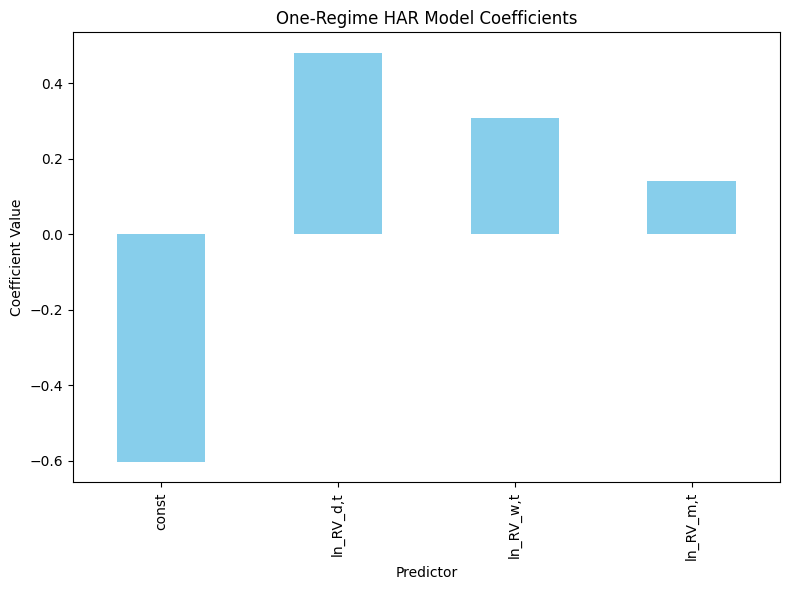

One-Regime Random Forest Feature Importances:
            Feature  Importance
0         ln_RV_d,t    0.588322
1         ln_RV_w,t    0.150750
2         ln_RV_m,t    0.067025
4            volume    0.046244
3              high    0.044522
9  Fear_Greed_Value    0.042369
5         UEMP15T26    0.017838
8          TB3SMFFM    0.016328
7           PERMITW    0.013391
6          UEMP27OV    0.013210


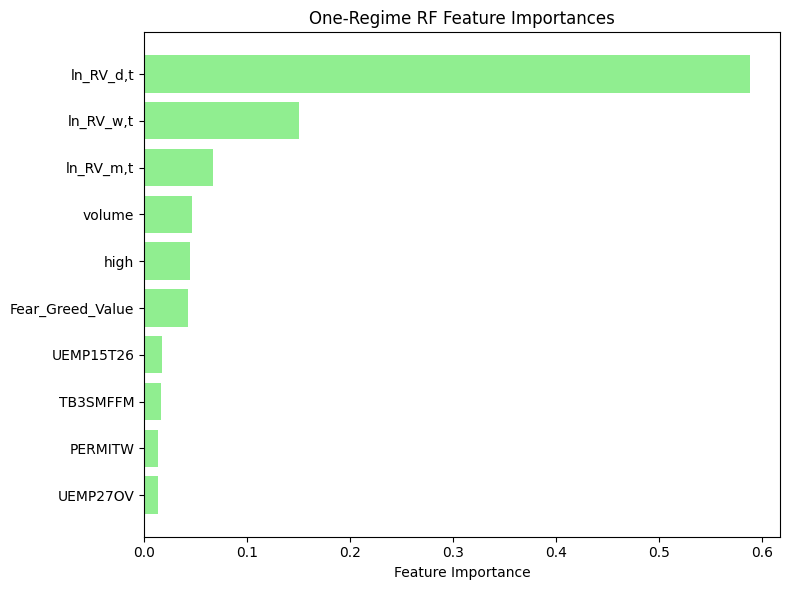


--- Interpretability for Two-Regime Models: High Volatility ---
Two-Regime HAR Model Coefficients for High Volatility:
           Coefficient       p-value
const        -7.052646  0.000000e+00
ln_RV_d,t     0.479931  1.640900e-16
ln_RV_w,t     0.251652  5.675310e-04
ln_RV_m,t     0.095325  3.928003e-02


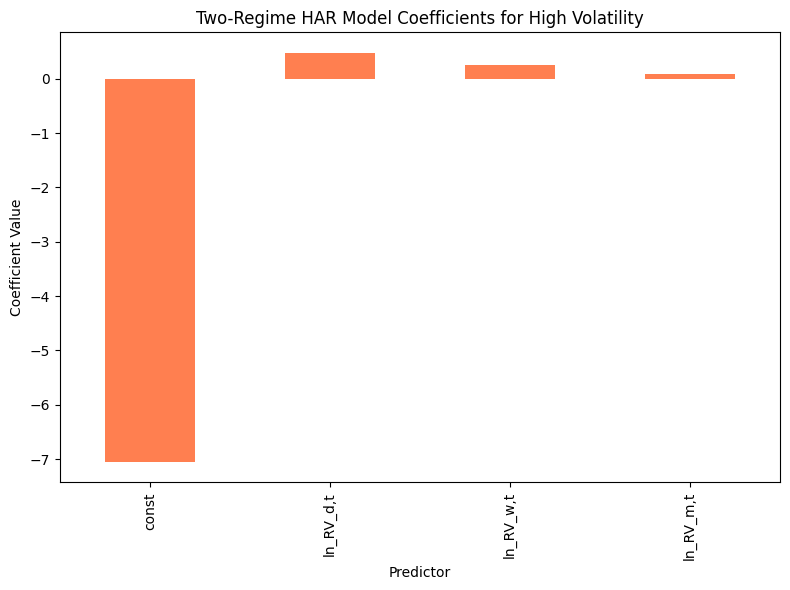

Two-Regime RF Feature Importances for High Volatility:
            Feature  Importance
0         ln_RV_d,t    0.446106
1         ln_RV_w,t    0.259987
2         ln_RV_m,t    0.069728
4            volume    0.067094
9  Fear_Greed_Value    0.063179
3              high    0.045677
7           PERMITW    0.017883
5         UEMP15T26    0.011777
8          TB3SMFFM    0.009808
6          UEMP27OV    0.008762


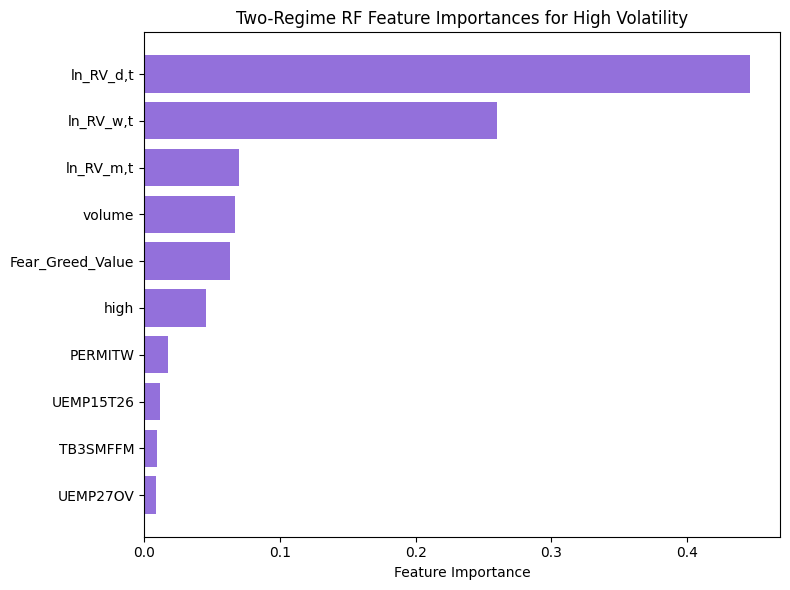


--- Interpretability for Two-Regime Models: Low Volatility ---
Two-Regime HAR Model Coefficients for Low Volatility:
           Coefficient       p-value
const        -7.147965  0.000000e+00
ln_RV_d,t     0.447101  1.865452e-27
ln_RV_w,t     0.254206  1.359867e-07
ln_RV_m,t     0.106831  1.031684e-02


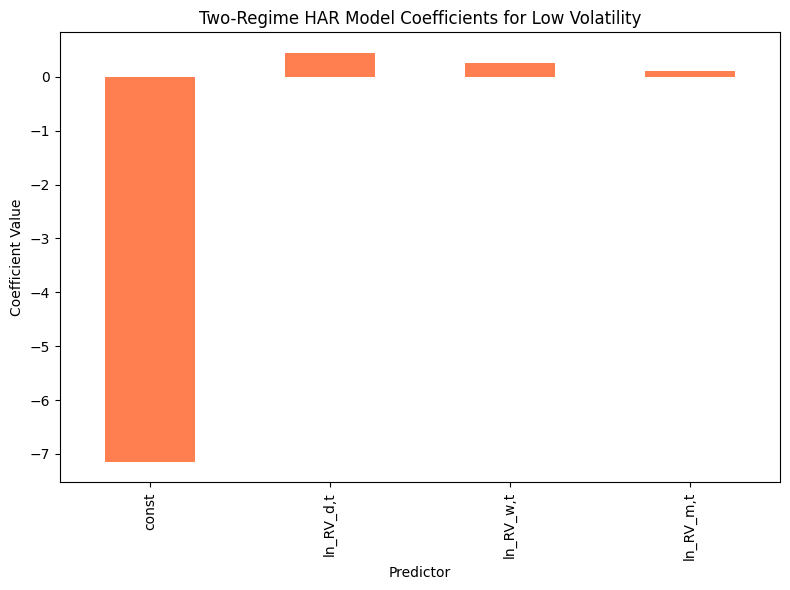

Two-Regime RF Feature Importances for Low Volatility:
            Feature  Importance
0         ln_RV_d,t    0.436626
1         ln_RV_w,t    0.179080
2         ln_RV_m,t    0.092266
3              high    0.085229
4            volume    0.062948
9  Fear_Greed_Value    0.056652
8          TB3SMFFM    0.028198
5         UEMP15T26    0.021790
7           PERMITW    0.020130
6          UEMP27OV    0.017080


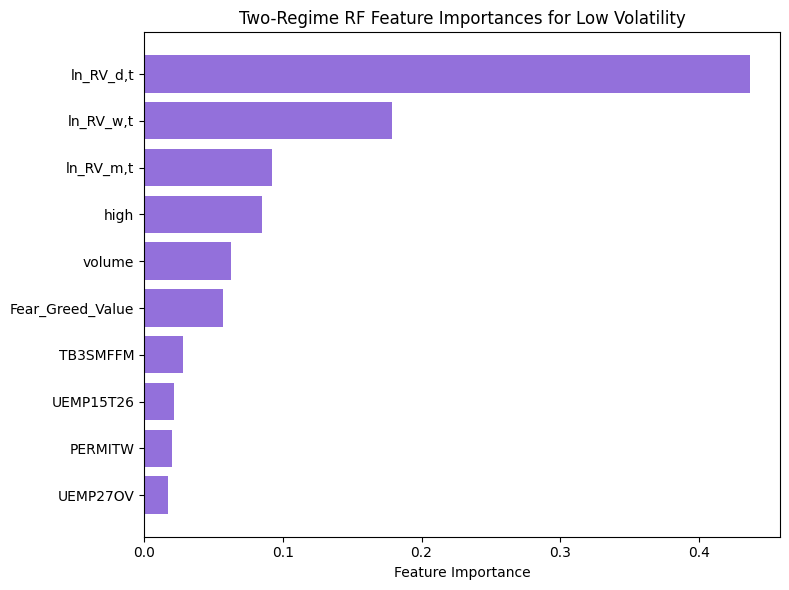

In [ ]:
# -------------------------------
# 1. One-Regime Model Interpretability
# -------------------------------

# --- HAR Model (One-Regime) ---
# Extract coefficients and p-values from the HAR OLS model
har_coef = har_model.params
har_pvalues = har_model.pvalues
har_summary = pd.DataFrame({'Coefficient': har_coef, 'p-value': har_pvalues})
print("One-Regime HAR Model Coefficients:")
print(har_summary)

# Plot the HAR model coefficients
plt.figure(figsize=(8, 6))
har_summary['Coefficient'].plot(kind='bar', color='skyblue')
plt.title('One-Regime HAR Model Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Predictor')
plt.tight_layout()
plt.show()

# --- Random Forest Model (One-Regime) ---
# Get feature importances from the RF model
rf_importance = rf.feature_importances_
rf_importance_df = pd.DataFrame({'Feature': features_1, 'Importance': rf_importance})
rf_importance_df = rf_importance_df.sort_values('Importance', ascending=False)
print("One-Regime Random Forest Feature Importances:")
print(rf_importance_df)

# Plot the RF feature importances
plt.figure(figsize=(8, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='lightgreen')
plt.xlabel('Feature Importance')
plt.title('One-Regime RF Feature Importances')
plt.gca().invert_yaxis()  # highest importance at the top
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Two-Regime Model Interpretability
# -------------------------------

for regime in ['High Volatility', 'Low Volatility']:
    
    print(f"\n--- Interpretability for Two-Regime Models: {regime} ---")
    
    # --- HAR Model (Two-Regime) ---
    model_har = two_reg_har_models[regime]
    coef = model_har.params
    pvals = model_har.pvalues
    summary_df = pd.DataFrame({'Coefficient': coef, 'p-value': pvals})
    print(f"Two-Regime HAR Model Coefficients for {regime}:")
    print(summary_df)
    
    # Plot the two-regime HAR coefficients
    plt.figure(figsize=(8, 6))
    summary_df['Coefficient'].plot(kind='bar', color='coral')
    plt.title(f'Two-Regime HAR Model Coefficients for {regime}')
    plt.ylabel('Coefficient Value')
    plt.xlabel('Predictor')
    plt.tight_layout()
    plt.show()
    
    # --- Random Forest Model (Two-Regime) ---
    model_rf = two_reg_rf_models[regime]
    rf_importance = model_rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features_2, 'Importance': rf_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    print(f"Two-Regime RF Feature Importances for {regime}:")
    print(importance_df)
    
    # Plot the two-regime RF feature importances
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='mediumpurple')
    plt.xlabel('Feature Importance')
    plt.title(f'Two-Regime RF Feature Importances for {regime}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [ ]:
# --- Combine HAR Model Coefficients ---
# Assume har_summary is the one-regime coefficient DataFrame with predictor names as the index
# and two_reg_har_models is a dict with keys 'High Volatility' and 'Low Volatility'
har_combined = pd.DataFrame({
    'One-Regime': har_model.params,
    'High Volatility': two_reg_har_models['High Volatility'].params,
    'Low Volatility': two_reg_har_models['Low Volatility'].params
})
har_combined.index.name = 'Predictor'
print("Combined HAR Coefficients:")
print(har_combined)

# --- Plot Grouped Bar Chart for HAR Coefficients ---
x = np.arange(len(har_combined))  # label locations for each predictor
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, har_combined['One-Regime'], width, label='One-Regime', color='skyblue')
ax.bar(x, har_combined['High Volatility'], width, label='High Volatility', color='coral')
ax.bar(x + width, har_combined['Low Volatility'], width, label='Low Volatility', color='lightgreen')

ax.set_ylabel('Coefficient Value')
ax.set_title('Comparison of HAR Model Coefficients Across Regimes')
ax.set_xticks(x)
ax.set_xticklabels(har_combined.index, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


NameError: name 'har_model' is not defined

In [ ]:
import pandas as pd

# -------------------------------
# 1. One-Regime Model LaTeX Tables
# -------------------------------

# One-Regime HAR Model Summary (coefficients and p-values)
har_summary_latex = har_summary.to_latex(
    index=True,
    float_format="%.4f",
    caption="One-Regime HAR Model Coefficients and p-values",
    label="tab:one_reg_har"
)
print("One-Regime HAR Model LaTeX Table:")
print(har_summary_latex)
print("\n")

# One-Regime RF Feature Importances
rf_importance_latex = rf_importance_df.to_latex(
    index=False,
    float_format="%.4f",
    caption="One-Regime Random Forest Feature Importances",
    label="tab:one_reg_rf"
)
print("One-Regime RF Feature Importances LaTeX Table:")
print(rf_importance_latex)
print("\n")

# -------------------------------
# 2. Two-Regime Model LaTeX Tables
# -------------------------------
for regime in ['High Volatility', 'Low Volatility']:
    # Two-Regime HAR Model Summary for the current regime
    model_har = two_reg_har_models[regime]
    coef = model_har.params
    pvals = model_har.pvalues
    summary_df = pd.DataFrame({'Coefficient': coef, 'p-value': pvals})
    summary_latex = summary_df.to_latex(
        index=True,
        float_format="%.4f",
        caption=f"Two-Regime HAR Model Coefficients and p-values for {regime}",
        label=f"tab:two_reg_har_{regime.replace(' ', '_')}"
    )
    print(f"Two-Regime HAR Model LaTeX Table for {regime}:")
    print(summary_latex)
    print("\n")
    
    # Two-Regime RF Feature Importances for the current regime
    model_rf = two_reg_rf_models[regime]
    rf_importance = model_rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features_2, 'Importance': rf_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    importance_latex = importance_df.to_latex(
        index=False,
        float_format="%.4f",
        caption=f"Two-Regime RF Feature Importances for {regime}",
        label=f"tab:two_reg_rf_{regime.replace(' ', '_')}"
    )
    print(f"Two-Regime RF Feature Importances LaTeX Table for {regime}:")
    print(importance_latex)
    print("\n")


One-Regime HAR Model LaTeX Table:
\begin{table}
\centering
\caption{One-Regime HAR Model Coefficients and p-values}
\label{tab:one_reg_har}
\begin{tabular}{lrr}
\toprule
{} &  Coefficient &  p-value \\
\midrule
const     &      -0.6024 &   0.0002 \\
ln\_RV\_d,t &       0.4808 &   0.0000 \\
ln\_RV\_w,t &       0.3076 &   0.0000 \\
ln\_RV\_m,t &       0.1406 &   0.0007 \\
\bottomrule
\end{tabular}
\end{table}



One-Regime RF Feature Importances LaTeX Table:
\begin{table}
\centering
\caption{One-Regime Random Forest Feature Importances}
\label{tab:one_reg_rf}
\begin{tabular}{lr}
\toprule
         Feature &  Importance \\
\midrule
       ln\_RV\_d,t &      0.5883 \\
       ln\_RV\_w,t &      0.1507 \\
       ln\_RV\_m,t &      0.0670 \\
          volume &      0.0462 \\
            high &      0.0445 \\
Fear\_Greed\_Value &      0.0424 \\
       UEMP15T26 &      0.0178 \\
        TB3SMFFM &      0.0163 \\
         PERMITW &      0.0134 \\
        UEMP27OV &      0.0132 \\
\bottomrule
\end

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_75710/2839699928.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  har_summary_latex = har_summary.to_latex(
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_75710/2839699928.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  rf_importance_latex = rf_importance_df.to_latex(
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_75710/2839699928.py:38: FutureWarning: In future versions `DataFrame.to

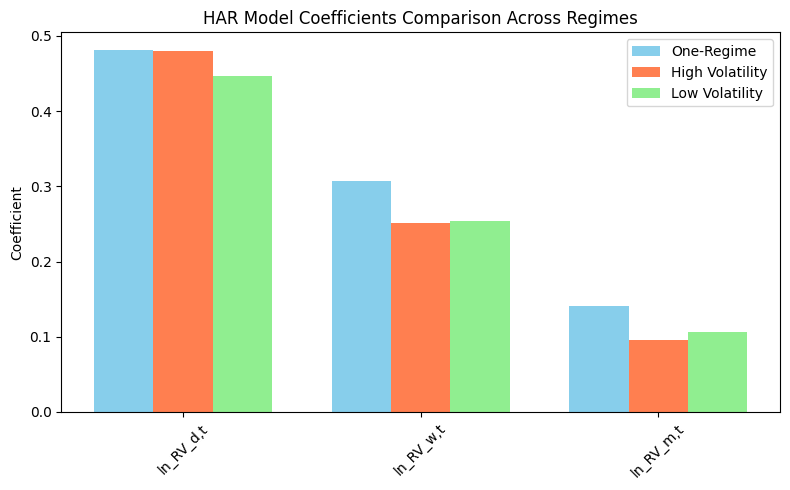

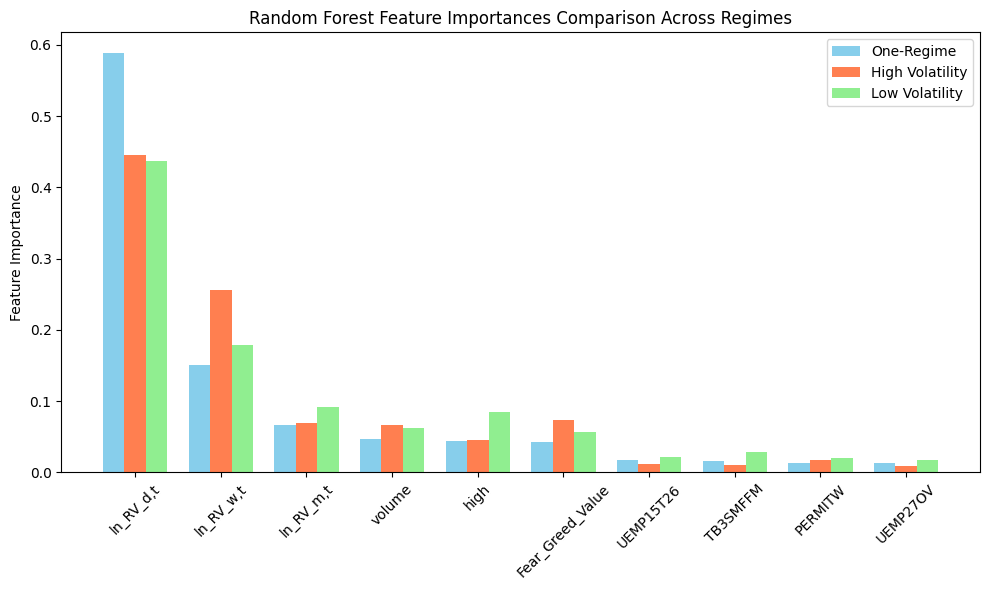

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

har_data = {
    'Predictor': ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t'],
    'One-Regime_Coefficient': [0.4808, 0.3076, 0.1406],
    'One-Regime_p-value': [0.0000, 0.0000, 0.0007],
    'Two-Regime_High_Coefficient': [0.4799, 0.2517, 0.0953],
    'Two-Regime_High_p-value': [ 0.0000, 0.0006, 0.0393],
    'Two-Regime_Low_Coefficient': [0.4471, 0.2542, 0.1068],
    'Two-Regime_Low_p-value': [0.0000, 0.0000, 0.0103]
}

rf_data = {
    'Predictor': [
        'ln_RV_d,t', 
        'ln_RV_w,t', 
        'ln_RV_m,t', 
        'volume',
        'high',
        'Fear_Greed_Value',
        'UEMP15T26',
        'TB3SMFFM',
        'PERMITW',
        'UEMP27OV'
    ],
    'One-Regime': [0.5883, 0.1507, 0.0670, 0.0462, 0.0445, 0.0424, 0.0178, 0.0163, 0.0134, 0.0132],
    'Two-Regime_High': [0.4461, 0.2560, 0.0697, 0.0671, 0.0457, 0.0741, 0.01178, 0.0098, 0.0179, 0.0087],
    'Two-Regime_Low': [0.4366, 0.1791, 0.0923, 0.0629, 0.0852, 0.0567, 0.0218, 0.0282, 0.0201, 0.0171]
}
rf_df = pd.DataFrame(rf_data)
rf_df.set_index('Predictor', inplace=True)

har_df = pd.DataFrame(har_data)
har_df.set_index('Predictor', inplace=True)


# Only plot the coefficient columns (not the p-values)
coeff_cols = ['One-Regime_Coefficient', 'Two-Regime_High_Coefficient', 'Two-Regime_Low_Coefficient']
har_coeffs = har_df[coeff_cols]

x = np.arange(len(har_coeffs))  # label locations
width = 0.25                    # width of each bar

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x - width, har_coeffs['One-Regime_Coefficient'], width, label='One-Regime', color='skyblue')
ax.bar(x,         har_coeffs['Two-Regime_High_Coefficient'], width, label='High Volatility', color='coral')
ax.bar(x + width, har_coeffs['Two-Regime_Low_Coefficient'],  width, label='Low Volatility', color='lightgreen')

ax.set_ylabel('Coefficient')
ax.set_title('HAR Model Coefficients Comparison Across Regimes')
ax.set_xticks(x)
ax.set_xticklabels(har_coeffs.index, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


import numpy as np
import matplotlib.pyplot as plt

cols = ['One-Regime', 'Two-Regime_High', 'Two-Regime_Low']
rf_importances = rf_df[cols]

x = np.arange(len(rf_importances))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, rf_importances['One-Regime'], width, label='One-Regime', color='skyblue')
ax.bar(x,         rf_importances['Two-Regime_High'], width, label='High Volatility', color='coral')
ax.bar(x + width, rf_importances['Two-Regime_Low'],  width, label='Low Volatility', color='lightgreen')

ax.set_ylabel('Feature Importance')
ax.set_title('Random Forest Feature Importances Comparison Across Regimes')
ax.set_xticks(x)
ax.set_xticklabels(rf_importances.index, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


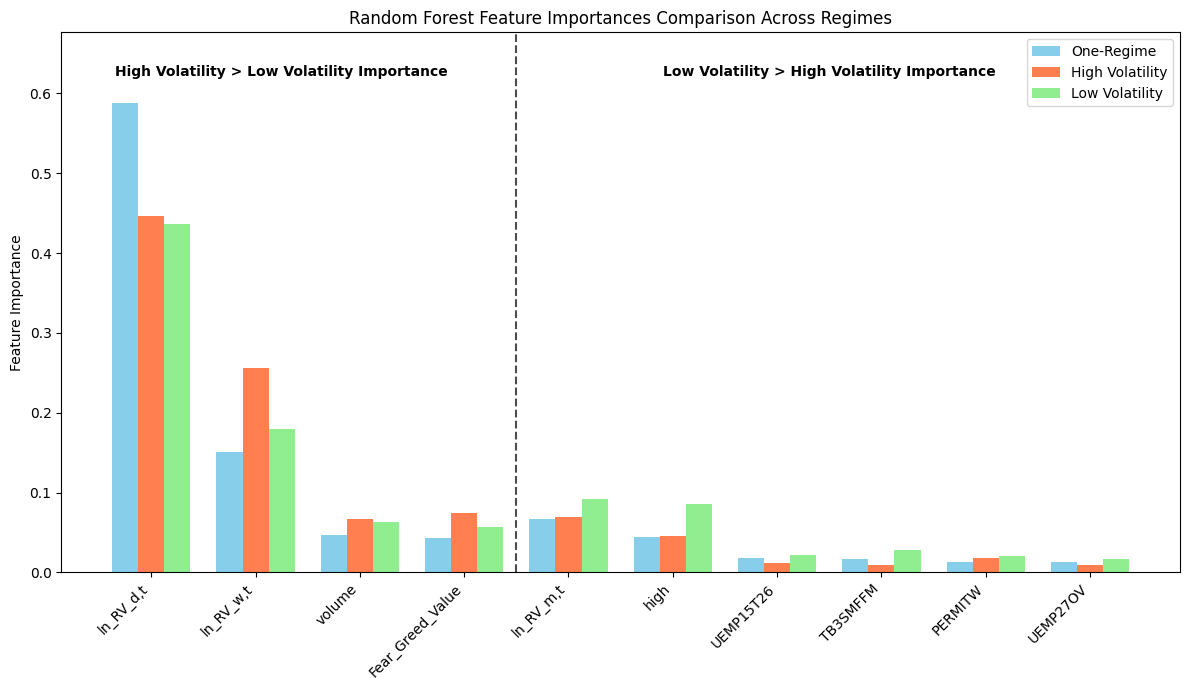

In [22]:
# Create DataFrame and set the index
rf_df = pd.DataFrame(rf_data)
rf_df.set_index('Predictor', inplace=True)

# Create a column to flag if the Two-Regime_High importance is greater than the Two-Regime_Low importance
rf_df['HighGreater'] = rf_df['Two-Regime_High'] > rf_df['Two-Regime_Low']

# Sort the DataFrame: features with Two-Regime_High > Two-Regime_Low come first
rf_df_sorted = rf_df.sort_values('HighGreater', ascending=False)

# Extract the columns to plot
cols = ['One-Regime', 'Two-Regime_High', 'Two-Regime_Low']
rf_importances = rf_df_sorted[cols]

# Count how many features have high regime importance > low regime importance
high_greater_count = rf_df_sorted['HighGreater'].sum()

# Plotting
x = np.arange(len(rf_importances))
width = 0.25
fig, ax = plt.subplots(figsize=(12, 7))

# Create the bars
ax.bar(x - width, rf_importances['One-Regime'], width, label='One-Regime', color='skyblue')
ax.bar(x, rf_importances['Two-Regime_High'], width, label='High Volatility', color='coral')
ax.bar(x + width, rf_importances['Two-Regime_Low'], width, label='Low Volatility', color='lightgreen')

# Add a vertical dotted line as separator
ax.axvline(x=high_greater_count - 0.5, color='black', linestyle='--', alpha=0.7)

# Add text labels on either side
ax.text(high_greater_count/2 - 0.75, max(rf_importances.max()) * 1.05, 
       'High Volatility > Low Volatility Importance', 
       ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.text((len(rf_importances) + high_greater_count)/2 - 0.5, max(rf_importances.max()) * 1.05, 
       'Low Volatility > High Volatility Importance', 
       ha='center', va='bottom', fontsize=10, fontweight='bold')

# Other plot settings
ax.set_ylabel('Feature Importance')
ax.set_title('Random Forest Feature Importances Comparison Across Regimes')
ax.set_xticks(x)
ax.set_xticklabels(rf_importances.index, rotation=45, ha='right')
ax.legend()

# Add a bit more space at the top for the labels
plt.ylim(0, max(rf_importances.max()) * 1.15)
plt.tight_layout()
plt.show()